# Árvores de regressão

Vamos utilizar a base de dados imobiliários de Boston, que pode ser baixada do módulo ```datasets``` do scikitlearn. Essa base de dados possui uma linha por cidade, o objetivo é prever, ou fornecer uma estimativa de ```MEDV```, ou o valor mediano de casas ocupadas pelo dono, dadas as demais variáveis usadas como explicativas.

A descrição das variáveis está abaixo:

| Variavel | Descrição|
|-|-|
|CRIM| taxa de crimes per-cápita da cidade | 
|ZN| proporção de terrenos residenciais zoneados para lotes com mais de 25.000 pés quadrados. |
|INDUS| proporção de acres de negócios não varejistas por cidade |
|CHAS |vale 1 se o terreno faz fronteira com o *Charles River*; 0 caso contrário |
|NOX| Concentração de óxido nítrico (em partes por 10 milhões) |
|RM| número médio de quartos por habitação |
|AGE| proporção de unidades ocupadas pelo proprietário construídas antes de 1940 |
|DIS| distâncias ponderadas até cinco centros de empregos de Boston |
|RAD| índice de acessibilidade a rodovias radiais |
|TAX| taxa de imposto sobre a propriedade de valor total por \\$10,000 |
|PTRATIO| razão pupilo-professor da cidade |
|B| $ 1000 (Bk - 0,63) ^ 2 $ onde Bk é a proporção de negros por cidade |
|LSTAT| \%status inferior da população |
|MEDV| (variável resposta) Valor mediano das casas ocupadas pelo proprietário em US $ 1.000|

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import pydotplus

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#boston = datasets.load_boston()
#X = pd.DataFrame(boston.data, columns = boston.feature_names)
#y = pd.DataFrame(boston.target, columns = ['MEDV'])

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]), 
                 columns=[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B','LSTAT']])
y = pd.DataFrame(raw_df.values[1::2, 2], columns=['MEDV'])

In [3]:
# por reforçar preconceitos a variável B será excluída das análises
# também vamos remorar a variável 'CHAS' pois, apesar de ser um numéro ela é categórica
X.drop(columns=['B', 'CHAS'], inplace=True, axis=1, level=0)

In [4]:
df_completo = pd.concat([X, y], axis=1)
df_completo.columns=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'LSTAT', 'MEDV']
df_completo.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


### 1. Certifique-se de que esta base está no formato adequado para o scikitlearn.
ok, essa tarefa é tão fácil que você vai até desconfiar. Mas é preciso ter confiança sobre os dados que se usa ;)

In [5]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   NOX      506 non-null    float64
 4   RM       506 non-null    float64
 5   AGE      506 non-null    float64
 6   DIS      506 non-null    float64
 7   RAD      506 non-null    float64
 8   TAX      506 non-null    float64
 9   PTRATIO  506 non-null    float64
 10  LSTAT    506 non-null    float64
 11  MEDV     506 non-null    float64
dtypes: float64(12)
memory usage: 47.6 KB


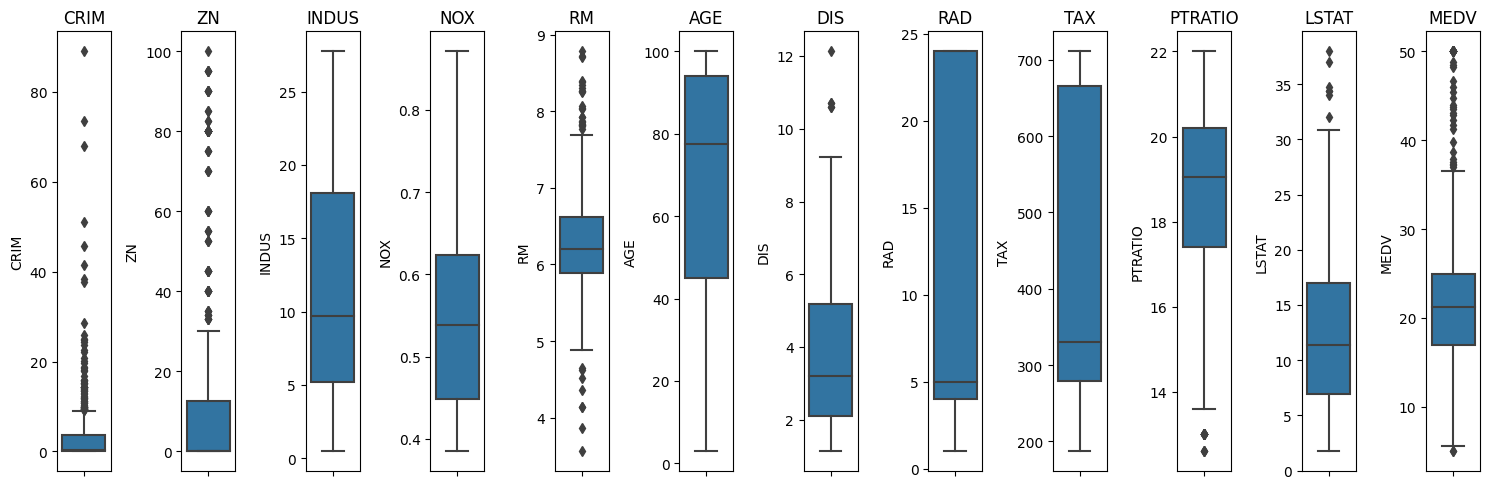

In [6]:
# Definindo o número de subplots e a disposição (1 linha e o número de colunas igual ao número de variáveis)
num_variaveis = df_completo.shape[1]  # Número de variáveis
fig, axs = plt.subplots(1, num_variaveis, figsize=(15, 5))

# Plotando cada boxplot em seu próprio gráfico
for i, coluna in enumerate(df_completo.columns):
    sns.boxplot(y=df_completo[coluna], ax=axs[i])
    axs[i].set_title(coluna)

plt.tight_layout()
plt.show()

In [7]:
# Aplicando a transformação logarítmica para reduzir o impact dos outliers nav análise
dados_transformados = np.log(df_completo+1)
dados_transformados.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.006300,2.944439,1.196948,0.430483,2.024853,4.192680,1.627278,0.693147,5.693732,2.791165,1.788421,3.218876
1,0.026944,0.000000,2.088153,0.384582,2.004314,4.380776,1.786261,1.098612,5.493061,2.933857,2.316488,3.117950
2,0.026924,0.000000,2.088153,0.384582,2.102303,4.128746,1.786261,1.098612,5.493061,2.933857,1.615420,3.575151
3,0.031857,0.000000,1.156881,0.377066,2.079192,3.845883,1.954757,1.386294,5.407172,2.980619,1.371181,3.538057
4,0.066770,0.000000,1.156881,0.377066,2.097650,4.010963,1.954757,1.386294,5.407172,2.980619,1.845300,3.616309


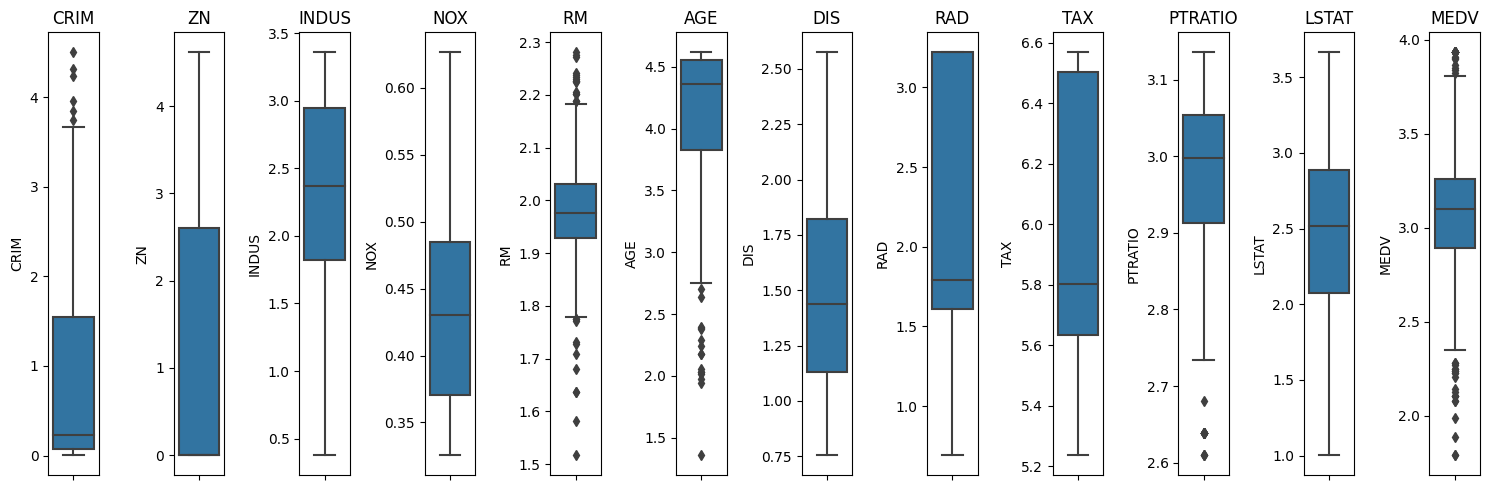

In [8]:
# Definindo o número de subplots e a disposição (1 linha e o número de colunas igual ao número de variáveis)
num_variaveis = dados_transformados.shape[1]  # Número de variáveis
fig, axs = plt.subplots(1, num_variaveis, figsize=(15, 5))

# Plotando cada boxplot em seu próprio gráfico
for i, coluna in enumerate(dados_transformados.columns):
    sns.boxplot(y=dados_transformados[coluna], ax=axs[i])
    axs[i].set_title(coluna)

plt.tight_layout()
plt.show()

### 2.  Visualize a matriz de correlação, e veja se aparentemente você encontra alguma variável com potencial preditivo interessante.

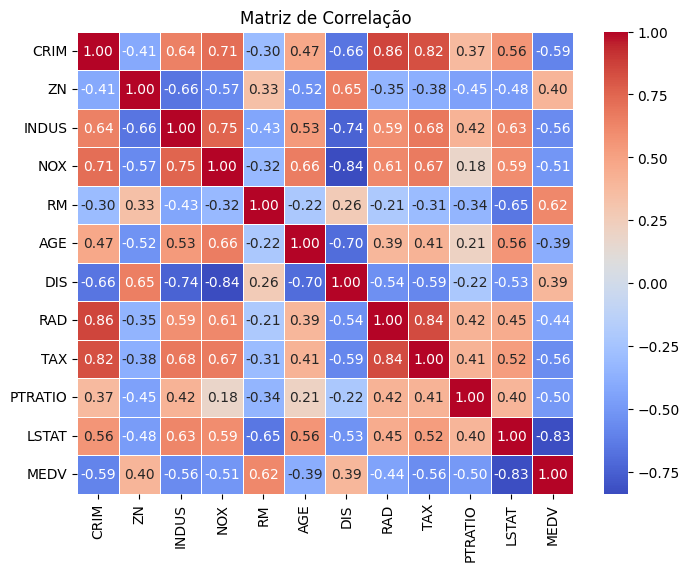

In [9]:
matriz_correlacao = dados_transformados.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

As variáveis CRIM, INDUS, NOX, AGE, RAD, TAX, PTRATIO e LSTAT possuem uma **boa correlação negativa** em relação a variável target.

As variáveis ZN e  e DISRM possuem uma **boa correlação positiva** com a variável targeeis.

### 3. Separe os dados em validação e teste

In [10]:
X = dados_transformados[['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']]
y = dados_transformados['MEDV']

# Separando 30% dos dados para validação
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=1980)

### 4. Treine duas árvores, uma com profundidade máxima = 8, outra com profundidade máxima = 2.

In [11]:
# Criando um modelo de árvore de regressão com profundidade máxima de 8
arvore_regressao_8 = DecisionTreeRegressor(max_depth=8, random_state=1980)

# Treinando o modelo
arvore_regressao_8.fit(X_treino, y_treino)

# Fazendo previsões com o cojunto de treino
y_pred_8_treino = arvore_regressao_8.predict(X_treino)

# Fazendo previsões no conjunto de teste
y_pred_8_teste = arvore_regressao_8.predict(X_teste)

In [12]:
# Criando um modelo de árvore de regressão com profundidade máxima de 2
arvore_regressao_2 = DecisionTreeRegressor(max_depth=2, random_state=1980)

# Treinando o modelo
arvore_regressao_2.fit(X_treino, y_treino)

# Fazendo previsões com o cojunto de treino
y_pred_2_treino = arvore_regressao_2.predict(X_treino)

# Fazendo previsões com o cojunto de teste
y_pred_2_teste = arvore_regressao_2.predict(X_teste)

### 5. Calcule o MSE de cada uma das árvores do item anterior para a base de treinamento e para a base de testes.

In [13]:
# Calculando o Mean Squared Error (MSE) para os conjuntos de treino
mse_treino_8 = mean_squared_error(y_treino, y_pred_8_treino)
mse_treino_2 = mean_squared_error(y_treino, y_pred_2_treino)

# Calculando o Mean Squared Error (MSE) para os conjuntos de teste
mse_teste_8 = mean_squared_error(y_teste, y_pred_8_teste)
mse_teste_2 = mean_squared_error(y_teste, y_pred_2_teste)

In [14]:
# Imprimindo os resultados
print('MSE para o conjunto de treino (profundidade 8):', mse_treino_8)
print('MSE para o conjunto de treino (profundidade 2):', mse_treino_2)
print('\nMSE para o conjunto de teste (profundidade 8):', mse_teste_8)
print('MSE para o conjunto de teste (profundidade 2):', mse_teste_2)

MSE para o conjunto de treino (profundidade 8): 0.0030444783297845007
MSE para o conjunto de treino (profundidade 2): 0.04182935799960684

MSE para o conjunto de teste (profundidade 8): 0.0537160434835403
MSE para o conjunto de teste (profundidade 2): 0.0628628907674292


### 6. Com base nos resultados do item anterior, qual árvore te parece mais adequada?

Ambas possuem um MSE baixo, mas a árvore com profundidade máxima de 8 é a mais adequada

### 7. Faça uma visualização gráfica dessa árvore. Vamos discutir importância de variável mais adiante, mas veja a sua árvore, e pense um pouco: qual variável te parece mais "importante" na árvore?

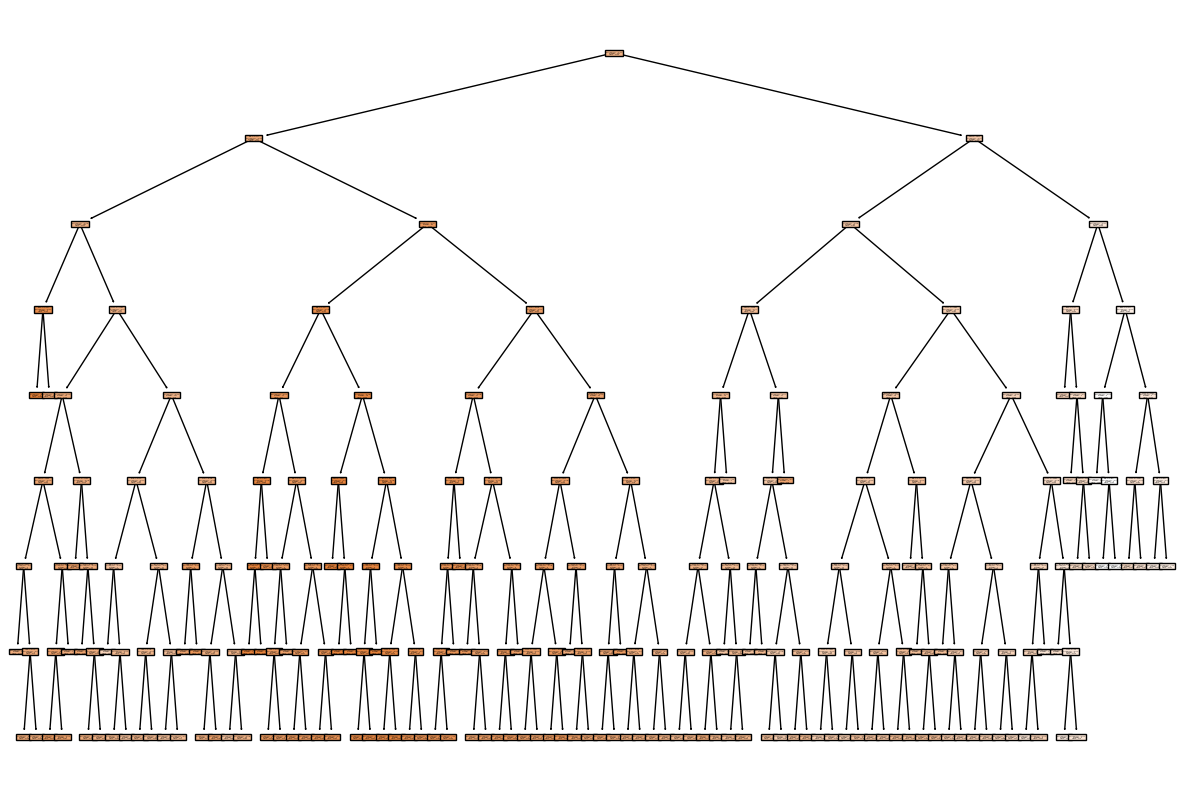

In [15]:
plt.rc('figure', figsize=(15, 10))
tp = tree.plot_tree(arvore_regressao_8, 
                    feature_names=list(X.columns),  
                    filled=True) 

In [16]:
# Como a árvore está díficil de ler, vamos calcular a importância das variáveis

# Obtém a importância das variáveis
importancia_variaveis = arvore_regressao_8.feature_importances_

# Associa cada importância a uma variável
nomes_variaveis = X.columns
importancia_variaveis_por_variavel = dict(zip(nomes_variaveis, importancia_variaveis))

# Ordena as variáveis pela importância
importancia_variaveis_ordenadas = dict(sorted(importancia_variaveis_por_variavel.items(), key=lambda item: item[1], reverse=True))

# Exibe a importância das variáveis
for variavel, importancia in importancia_variaveis_ordenadas.items():
    print(f'{variavel}: {importancia}')

LSTAT: 0.5427865673978627
RM: 0.227290361310787
CRIM: 0.08390043054649365
NOX: 0.05867259438123728
DIS: 0.04660653791874771
TAX: 0.017543591663537948
PTRATIO: 0.0074193696094942375
AGE: 0.006608463428273053
ZN: 0.0041630890093691695
INDUS: 0.003064329368398907
RAD: 0.0019446653657983221


A variável LSTAT parece ser a mais importante para a árvore de regressão